# Running Sentiment Analysis on Illinois Tweets during shutdown

Used Vader Sentiment Analysis to conduct sentiment analysis on all tweets. 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.style as style
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import pytz

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Link to this Sentiment Analyzer: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [24]:
tqdm.pandas() # Allows us to see progress bars on pandas.apply methods

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [25]:
style.use('fivethirtyeight')

In [26]:
# Reading in state data

il_shutdown_df = pd.read_csv('./data/shutdown_data/IL_full_shutdown.csv', low_memory=False, index_col='date')
ga_shutdown_df = pd.read_csv('./data/shutdown_data/GA_full_shutdown.csv', low_memory=False, index_col='date')
tx_shutdown_df = pd.read_csv('./data/shutdown_data/TX_full_shutdown.csv', low_memory=False, index_col='date')

In [27]:
def set_index_datetime_in_timezone(data, timezone):
    '''
    Takes a list of dataframes formatted [dataframe, timezone]
    Sets index of each dataframe to datetime and sorts the dataframe
    
    See pytz.timezone() documentation for all acceptable timezones.
    For the US, use the following:
    
    US/Central
    US/Eastern
    US/Mountain
    US/Pacific
    '''
    
    # Create datetime in local timezone
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)
    data.index = data.index.tz_convert(timezone)


In [28]:
df_list = [
    [il_shutdown_df, 'US/Central'],
    [ga_shutdown_df, 'US/Eastern'],
    [tx_shutdown_df, 'US/Eastern']
]

for df in df_list:
    set_index_datetime_in_timezone(df[0], df[1])

In [29]:
il_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'springfield', 'pritzker', 'virus']
ga_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'atlanta', 'kemp', 'virus']
tx_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'austin', 'abbott', 'virus']

In [30]:
il_shutdown_df_covid = il_shutdown_df.copy()[il_shutdown_df['text'].str.contains('|'.join(il_covid_terms))]
ga_shutdown_df_covid = ga_shutdown_df.copy()[ga_shutdown_df['text'].str.contains('|'.join(ga_covid_terms))]
tx_shutdown_df_covid = tx_shutdown_df.copy()[tx_shutdown_df['text'].str.contains('|'.join(tx_covid_terms))]

In [31]:
# provided from link 
def sentiment_analyzer_scores(sentence):    
    score = analyser.polarity_scores(sentence)
    return score

In [32]:
# Analyze our city data
def vader_analyzer(data):
    '''
    Takes pandas dataframe of info scraped from twitter and performs sentiment
    analysis. Creates 5 new columns to be used in sentiment analysis:
    'neg_score' - negative score
    'neu_score' - neutral score
    'pos_score' - positive score
    'compound_score' - (score < -0.05 = negative
                        score between -0.05 and 0.05 = neutral
                        score > 0.05 = positive)
    '''
    data['sentiment_analysis'] = data.progress_apply(lambda x: sentiment_analyzer_scores(x['text']), axis=1)
    data['neg_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neg'])
    data['neu_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neu'])
    data['pos_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['pos'])
    data['compound_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['compound'])

In [33]:
def create_time_cols(data, timezone):
    # Creating month_day_hour column for graphing purposes
    data['month_day_hour'] = data.index.strftime(date_format='%m%d%H')

In [49]:
def plot_state_sentiment(data, timezone, covid_only=False, is_reopen=False):
#     # Creating this variable for x tick marks
    hour_group = data.resample('h').mean()['compound_score']
    days = data.resample('D').mean().index.strftime('%m-%d')
    
    timezone_map = {'eastern': -4,
                'central': -5,
                'mountain': -6,
                'pacific': -7}
    
    # Create sentiment plot
    plt.figure(figsize=(32, 6))
    
    sns.lineplot(data=data,
                 x='month_day_hour',
                 y='compound_score', 
                 linewidth=2.5, 
                 color='blue')
    
    plt.axhspan(-.05, .05, color='gray', alpha=0.3)
    plt.axhspan(.05, np.percentile(data['compound_score'], 90), color='green', alpha=0.3)
    plt.axhspan(-.05, np.percentile(data['compound_score'], 10), color='red', alpha=0.3)
    
    plt.xticks(range(-(24 + timezone_map[timezone]), # Need to offset the xticks to account for timezone shift upon scraping 
                     len(hour_group), # hour_group is just the original data grouped by hour, should be divisible by 24
                     24),
               days.unique())
    
    # Sorry this isn't human readable :( it returns the date in the proper format to be plotted
    plt.axvline(str(timeline_dict[data['state'].reset_index().loc[0, 'state']] [is_reopen])[4:] + '00') 
    
    plt.legend(['_', 'Date shutdown was announced'])
    
    if covid_only:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms')
    else:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Compound Score')
    plt.show();

In [50]:
def analyze_and_plot_sentiment(data, timezone, covid_only=False, is_reopen=False):
    vader_analyzer(data)
    create_time_cols(data, timezone)
    plot_state_sentiment(data, timezone, covid_only)

In [51]:
# Stores the shutdown and reopening dates as YYYYMMDD integers

timeline_dict = {
    'FL': [20200401, 20200429],
    'TX': [20200331, 20200518],
    'NJ': [20200316, 20200609],
    'NY': [20200322, 20200613],
    'IL': [20200320, 20200529],
    'GA': [20200402, 20200601],
    'OH': [20200322, 20200526],
    'MI': [20200323, 20200608]
}

In [52]:
covid_term_data = [
    [il_shutdown_df_covid, 'central', False], 
    [ga_shutdown_df_covid, 'eastern', False],
    [tx_shutdown_df_covid, 'eastern', False]
]

In [53]:
# Initializing Vader model 
analyser = SentimentIntensityAnalyzer()

100%|██████████| 21811/21811 [00:00<00:00, 1147699.31it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C48FFBEB48> has a label of '_' which cannot be automatically added to the legend.


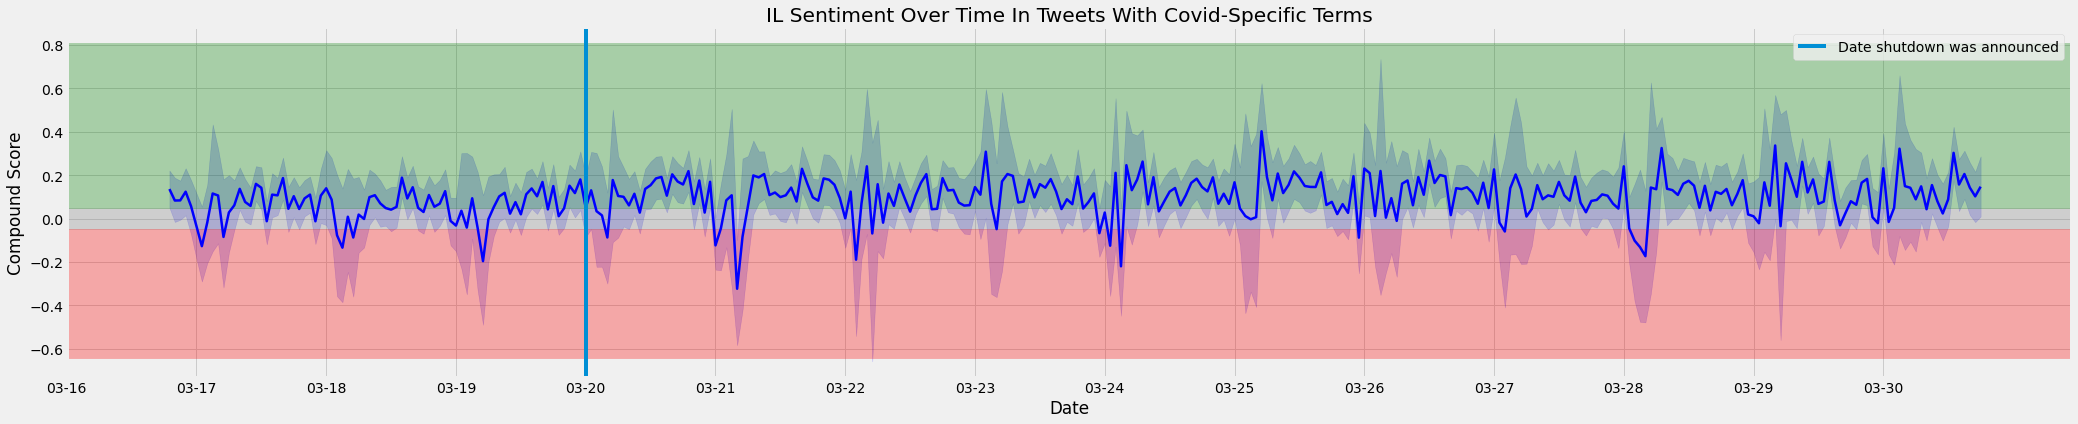

100%|██████████| 10050/10050 [00:00<00:00, 1116392.69it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C493E76548> has a label of '_' which cannot be automatically added to the legend.


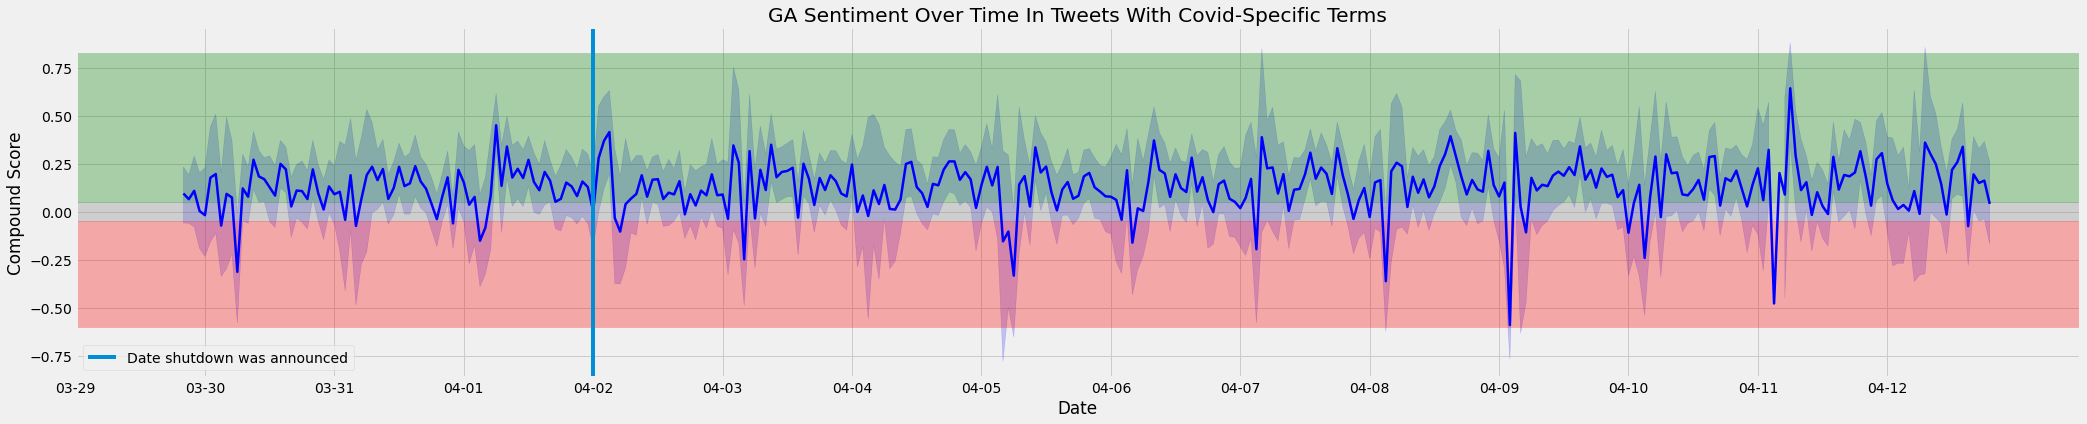

100%|██████████| 6386/6386 [00:00<00:00, 1064029.93it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C483C500C8> has a label of '_' which cannot be automatically added to the legend.


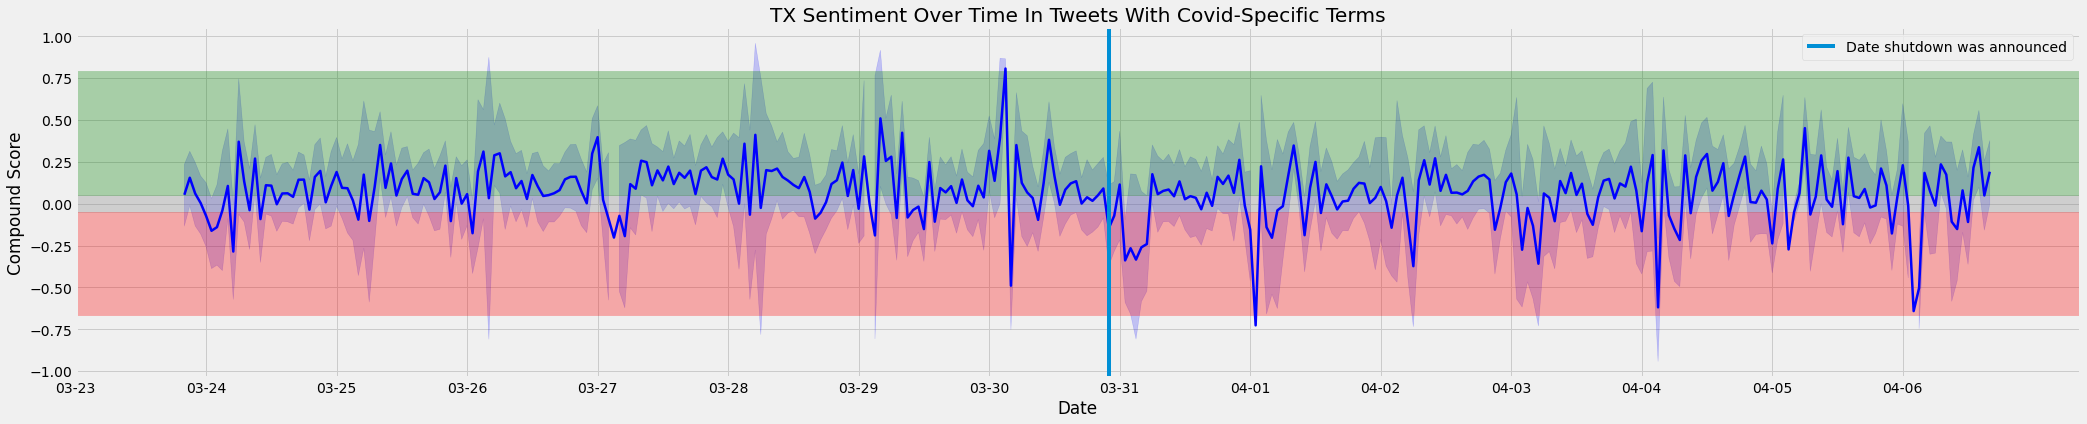

In [54]:
# Iterates through each item in covid_term_data and runs it through analyze_and_plot_sentiment

for i in range(len(covid_term_data)):
    analyze_and_plot_sentiment(covid_term_data[i][0], # data
                               covid_term_data[i][1], # timezone
                               covid_only=True, # search terms
                               is_reopen=covid_term_data[i][2] # whether or not state is reopen, this will change the vertical line's position on visual
                              )

In [55]:
# Dataframe, timezone, boolean for is_reopen
general_terms_data = [
    [il_shutdown_df, 'central', False], 
    [ga_shutdown_df, 'eastern', False],
    [tx_shutdown_df, 'eastern', False]
]

100%|██████████| 106971/106971 [00:00<00:00, 1162466.07it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C483192FC8> has a label of '_' which cannot be automatically added to the legend.


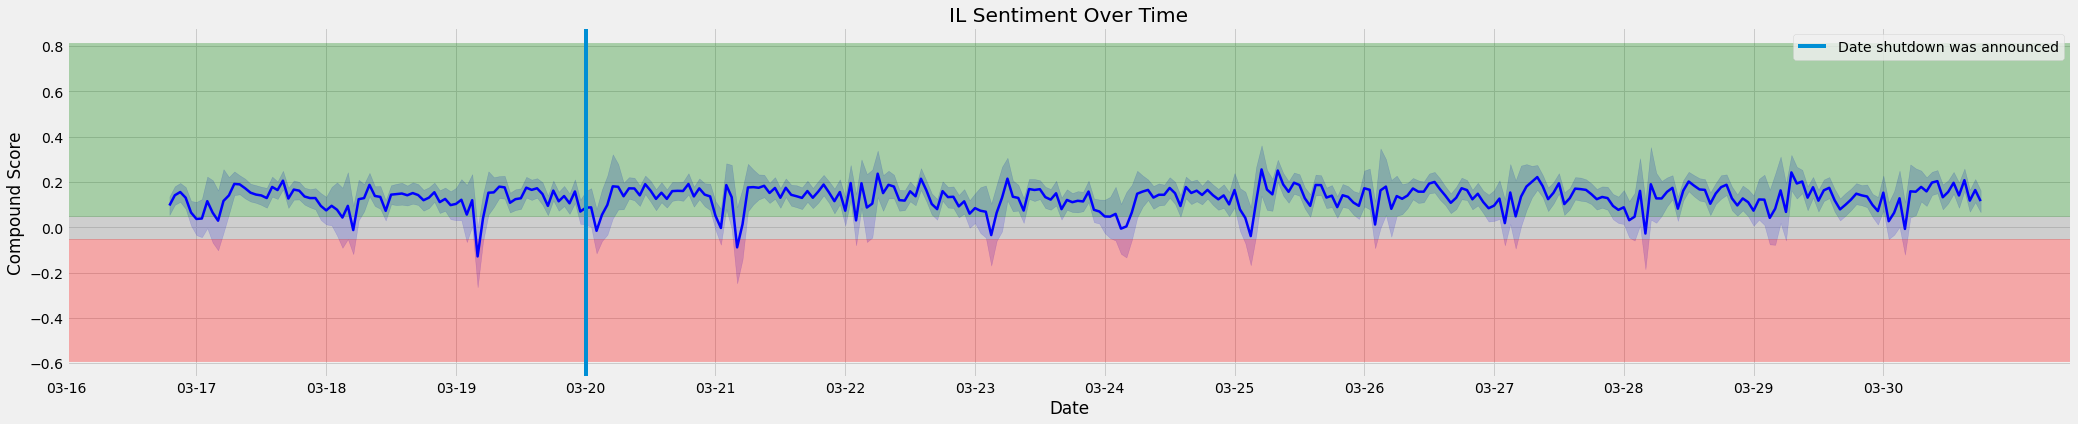

100%|██████████| 69259/69259 [00:00<00:00, 1135142.96it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C48B761288> has a label of '_' which cannot be automatically added to the legend.


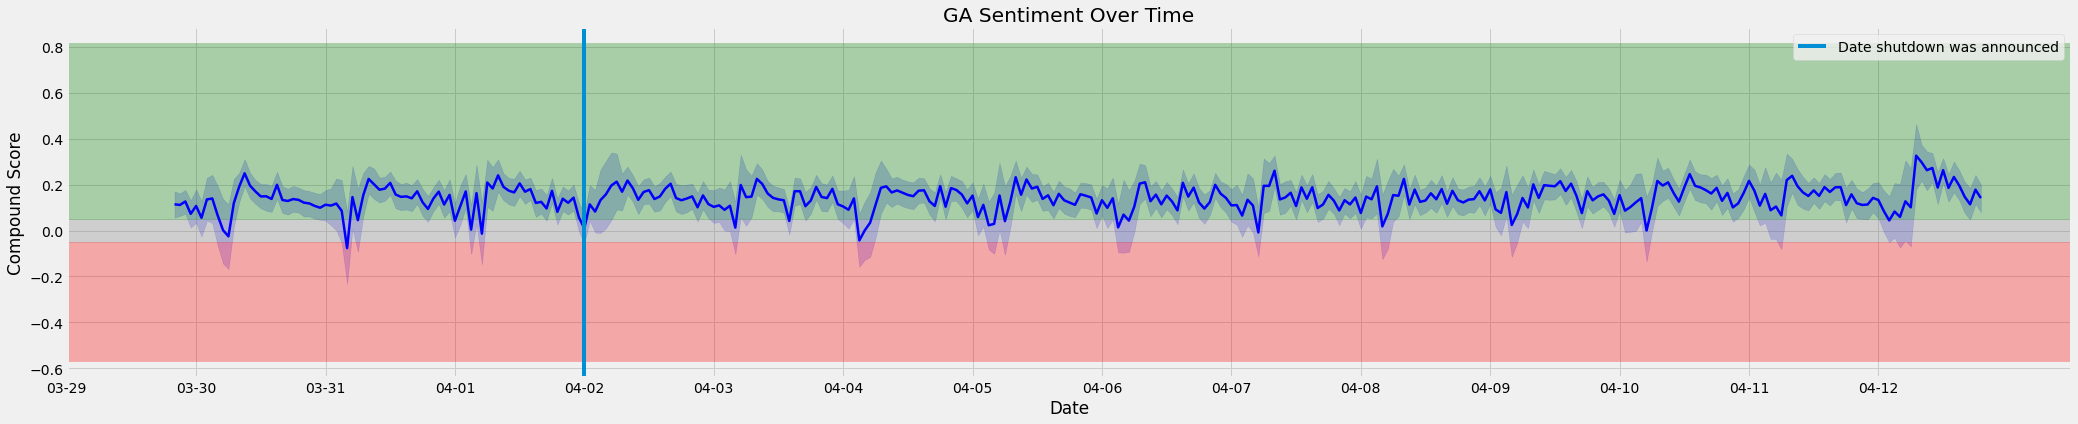

100%|██████████| 37458/37458 [00:00<00:00, 1134845.20it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C48A990D88> has a label of '_' which cannot be automatically added to the legend.


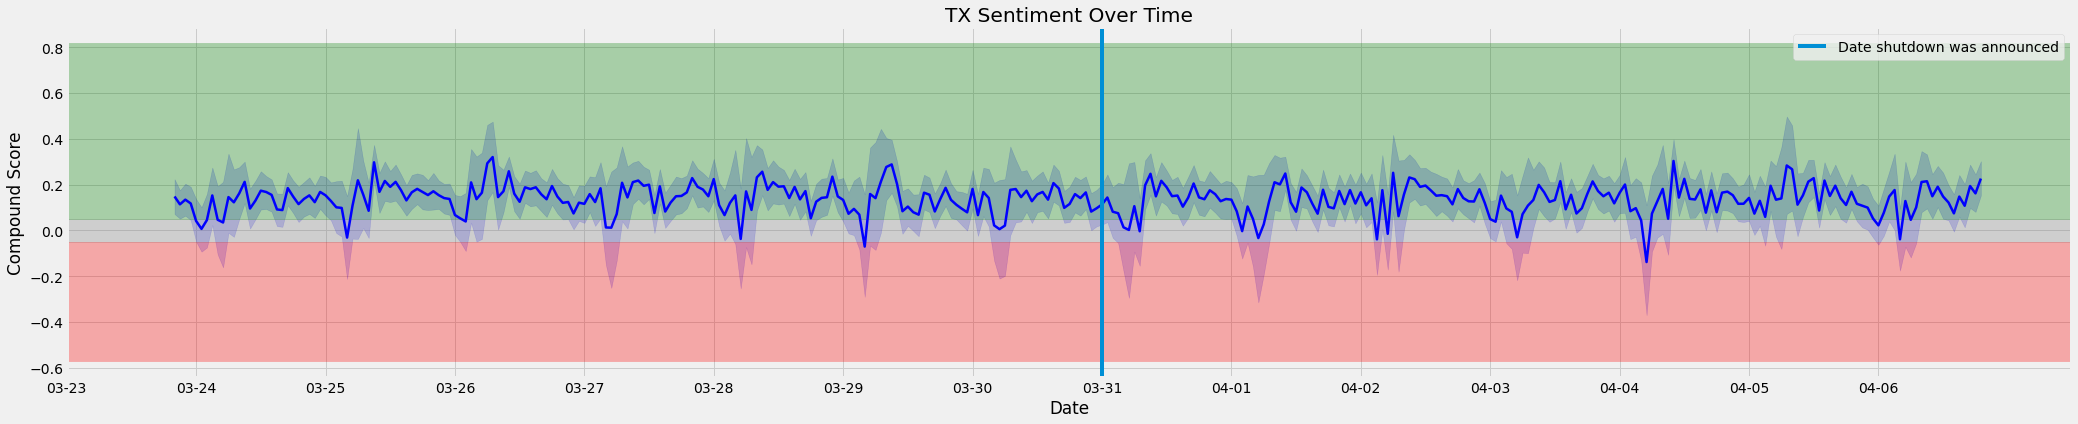

In [56]:
for i in range(len(general_terms_data)):
    analyze_and_plot_sentiment(general_terms_data[i][0], # data
                               general_terms_data[i][1], # timezone
                               covid_only=False, # search terms
                               is_reopen=covid_term_data[i][2] # whether or not state is reopen, this will change the vertical line's position on visual
                              )

In [57]:
il_shutdown_df.to_csv('./data/sentiment_data/IL_shutdown_sentiment.csv', index=False)
ga_shutdown_df.to_csv('./data/sentiment_data/GA_shutdown_sentiment.csv', index=False)
tx_shutdown_df.to_csv('./data/sentiment_data/TX_shutdown_sentiment.csv', index=False)